# 一．特征列feature_column

通常在结构化实施特征工程时候使用，图像或者文本数据一般不会用到特征列．

## 特征列用法概述

使用特征列可以将类别特征转换为one-hot编码特征，将连续特征构建分桶特征，以及对多个特征生成交叉特征等等。

要创建特征列，请调用 tf.feature_column 模块的函数。该模块中常用的九个函数如下图所示，所有九个函数都会返回一个 Categorical-Column 或一个 Dense-Column 对象，但却不会返回 bucketized_column，后者继承自这两个类。

![](./../data/特征列9种.jpg)

注意：所有的Catogorical Column类型最终都要通过indicator_column转换成Dense Column类型才能传入模型！

* numeric_column 数值列，最常用。


* bucketized_column 分桶列，由数值列numeric_column生成，可以由一个数值列出多个特征，one-hot编码。


* categorical_column_with_identity 分类标识列，one-hot编码，相当于分桶列每个桶为1个整数的情况。


* categorical_column_with_vocabulary_list 分类词汇列，one-hot编码，由list指定词典。


* categorical_column_with_vocabulary_file 分类词汇列，由文件file指定词典。


* categorical_column_with_hash_bucket 哈希列，整数或词典较大时采用。


* indicator_column 指标列，由Categorical Column生成，one-hot编码


* embedding_column 嵌入列，由Categorical Column生成，嵌入矢量分布参数需要学习。嵌入矢量维数建议取类别数量的 4 次方根。


* crossed_column 交叉列，可以由除categorical_column_with_hash_bucket的任意分类列构成。

使用特征列解决Titanic生存问题的范例

In [7]:
from datetime import datetime
import pandas as pd
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
from tensorflow.keras import layers,models

In [22]:
def printlog(info):
    print('\n==========================================================%s'%(datetime.now().strftime('%Y-%m-%d %H:%M:%S')))
    print('%s\n'%(info))

In [23]:
## 构建数据管道
printlog('step1: prepare dataset')

dftrain_raw = pd.read_csv('./../data/titanic/train.csv')
dftest_raw = pd.read_csv('./../data/titanic/test.csv')
df_raw = pd.concat([dftrain_raw,dftest_raw])
print(len(df_raw))
def prepare(dfraw):
    dfdata = dfraw.copy()
    dfdata.columns = [x.lower() for x in dfdata.columns]
    dfdata.rename(columns={'survived':'label'},inplace=True)
    dfdata = dfdata.drop(['passengerid','name'],axis=1)
    for col,dtype in dict(dfdata.dtypes).items():
        if dfdata[col].hasnans:
            dfdata[col+'_nan'] = pd.isna(dfdata[col]).astype('int32')
            if dtype not in [np.object,np.str,np.unicode]:
                dfdata[col].fillna(dfdata[col].mean(),inplace=True)
            else:
                dfdata[col].fillna('',inplace=True)
    return dfdata

dfdata = prepare(df_raw)
dftrain = dfdata.iloc[0:len(dftrain_raw),:]
dftest = dfdata.iloc[len(dftrain_raw):,:]

##导入数据
def df_to_dataset(df,shuffle=True,batch_size=32):
    dfdata = df.copy()
    if 'label' not in dfdata.columns:
        ds = tf.data.Dataset.from_tensor_slices(dfdata.to_dict(orient='list'))
    else:
        labels = dfdata.pop('label')
        ds = tf.data.Dataset.from_tensor_slices((dfdata.to_dict(orient='list'),labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=(len(dfdata)))
    ds = ds.batch(batch_size)
    return ds

ds_train = df_to_dataset(dftrain)
ds_test = df_to_dataset(dftest)


==========================================================2020-04-18 22:22:44
step1: prepare dataset

891


In [24]:
print(len(dftrain))
print(len(dftest))

712
179


In [37]:
## 定义特征列
printlog('step2: build feature columns')

feature_columns =[]
## 数值列
for col in ['age','fare','parch','sibsp'] + [c for c in dfdata.columns if c.endswith('_nan')]:
    feature_columns.append(tf.feature_column.numeric_column(col))
    
## 分桶列
age_buckets = tf.feature_column.bucketized_column(tf.feature_column.numeric_column('age'),boundaries=[
    # 18,25,30,35,40,45,50,55,60,65
    18,30,50,65
])
feature_columns.append(age_buckets)

## 类别列
sex = tf.feature_column.indicator_column(
    tf.feature_column.categorical_column_with_vocabulary_list(
    key='sex',vocabulary_list=['male','female']
    )
)
feature_columns.append(sex)

pclass_cat = tf.feature_column.categorical_column_with_vocabulary_list(key='pclass',vocabulary_list=[1,2,3])
pclass = tf.feature_column.indicator_column(pclass_cat)
feature_columns.append(pclass)

ticket = tf.feature_column.indicator_column(tf.feature_column.categorical_column_with_hash_bucket('ticket',3))
feature_columns.append(ticket)

embarked = tf.feature_column.indicator_column(tf.feature_column.categorical_column_with_vocabulary_list(
    key='embarked',vocabulary_list=['S','C','B']))
feature_columns.append(embarked)

##嵌入列
cabin = tf.feature_column.embedding_column(tf.feature_column.categorical_column_with_hash_bucket('cabin',32),2)
feature_columns.append(cabin)

##交叉列
crossed_feature = tf.feature_column.indicator_column(tf.feature_column.crossed_column([age_buckets,pclass_cat],hash_bucket_size=15))
feature_columns.append(crossed_feature)


==========================================================2020-04-18 22:53:07
step2: build feature columns



In [38]:
## 定义模型
printlog('step3: define model')
tf.keras.backend.clear_session()
model = tf.keras.Sequential([
    layers.DenseFeatures(feature_columns=feature_columns),
    layers.Dense(64,activation='relu'),
    layers.Dense(64,activation='relu'),
    layers.Dense(16,activation='relu'),
    layers.Dense(1,activation='sigmoid')
])



==========================================================2020-04-18 22:53:09
step3: define model



In [39]:
## 训练模型
printlog('step4: train model')
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
history = model.fit(ds_train,validation_data=ds_test,epochs = 20)



==========================================================2020-04-18 22:53:10
step4: train model

Train for 23 steps, validate for 6 steps
Epoch 1/20
23/23 [==============================] - 1s 29ms/step - loss: 0.7609 - accuracy: 0.6489 - val_loss: 0.6945 - val_accuracy: 0.6313
Epoch 2/20
23/23 [==============================] - 0s 3ms/step - loss: 0.6418 - accuracy: 0.6854 - val_loss: 0.5965 - val_accuracy: 0.6648
Epoch 3/20
23/23 [==============================] - 0s 3ms/step - loss: 0.6317 - accuracy: 0.6966 - val_loss: 0.6469 - val_accuracy: 0.6648
Epoch 4/20
23/23 [==============================] - 0s 3ms/step - loss: 0.6332 - accuracy: 0.6896 - val_loss: 0.6013 - val_accuracy: 0.7039
Epoch 5/20
23/23 [==============================] - 0s 3ms/step - loss: 0.5999 - accuracy: 0.6938 - val_loss: 0.5518 - val_accuracy: 0.7151
Epoch 6/20
23/23 [==============================] - 0s 3ms/step - loss: 0.5818 - accuracy: 0.7121 - val_loss: 0.6049 - val_accuracy: 0.6760
Epoch 7/20
23/23 [=


==========================================================2020-04-18 22:53:17
step5: eval model

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_features (DenseFeature multiple                  64        
_________________________________________________________________
dense (Dense)                multiple                  2624      
_________________________________________________________________
dense_1 (Dense)              multiple                  4160      
_________________________________________________________________
dense_2 (Dense)              multiple                  1040      
_________________________________________________________________
dense_3 (Dense)              multiple                  17        
Total params: 7,905
Trainable params: 7,905
Non-trainable params: 0
_________________________________________________________________


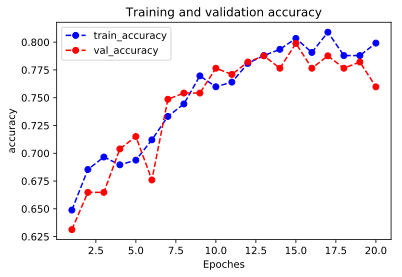

In [40]:
## 评估模型
printlog('step5: eval model')
model.summary()

%matplotlib inline
%config InlineBackend.figure_format='svg'
import matplotlib.pyplot as plt

def plot_metric(history,metric):
    train_metrics = history.history[metric]
    val_metrics = history.history['val_'+metric]
    epochs = range(1,len(train_metrics)+1)
    plt.plot(epochs,train_metrics,'bo--')
    plt.plot(epochs,val_metrics,'ro--')
    plt.title('Training and validation ' + metric)
    plt.xlabel('Epoches')
    plt.ylabel(metric)
    plt.legend(['train_'+metric,'val_'+metric])
    plt.show()
    pass
plot_metric(history,'accuracy')

# 二．激活函数

激活函数在深度学习中扮演着非常重要的角色，它给网络赋予了非线性，从而使得神经网络能够拟合任意复杂的函数。

如果没有激活函数，无论多复杂的网络，都等价于单一的线性变换，无法对非线性函数进行拟合。

目前，深度学习中最流行的激活函数为 relu, 但也有些新推出的激活函数，例如 swish、GELU 据称效果优于relu激活函数。

激活函数的综述介绍可以参考下面两篇文章。

[《一文概览深度学习中的激活函数》](https://zhuanlan.zhihu.com/p/98472075)

https://zhuanlan.zhihu.com/p/98472075

[《从ReLU到GELU,一文概览神经网络中的激活函数》](https://zhuanlan.zhihu.com/p/98863801)

https://zhuanlan.zhihu.com/p/98863801

* tf.nn.sigmoid：将实数压缩到0到1之间，一般只在二分类的最后输出层使用。主要缺陷为存在梯度消失问题，计算复杂度高，输出不以0为中心。

![](./../data/sigmoid.png)

* tf.nn.softmax：sigmoid的多分类扩展，一般只在多分类问题的最后输出层使用。

![](./../data/softmax说明.jpg)

* tf.nn.tanh：将实数压缩到-1到1之间，输出期望为0。主要缺陷为存在梯度消失问题，计算复杂度高。

![](./../data/tanh.png)

* tf.nn.relu：修正线性单元，最流行的激活函数。一般隐藏层使用。主要缺陷是：输出不以0为中心，输入小于0时存在梯度消失问题(死亡relu)。

![](./../data/relu.png)

* tf.nn.leaky_relu：对修正线性单元的改进，解决了死亡relu问题。

![](./../data/leaky_relu.png)

* tf.nn.elu：指数线性单元。对relu的改进，能够缓解死亡relu问题。

![](./../data/elu.png)

* tf.nn.selu：扩展型指数线性单元。在权重用tf.keras.initializers.lecun_normal初始化前提下能够对神经网络进行自归一化。不可能出现梯度爆炸或者梯度消失问题。需要和Dropout的变种AlphaDropout一起使用。

![](./../data/selu.png)

* tf.nn.swish：自门控激活函数。谷歌出品，相关研究指出用swish替代relu将获得轻微效果提升。

![](./../data/swish.png)

* gelu：高斯误差线性单元激活函数。在Transformer中表现最好。tf.nn模块尚没有实现该函数。

![](./../data/gelu.png)

In [42]:
## 可以在模型中使用激活函数，一．直接作为某层的activation参数指定，二．显式添加layers.Activation激活层．
# model.add(layers.Activation(tf.nn.softmax))